# The autoregressive model: AR(p) 

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

## Simulate a AR(2) process 

In [4]:
np.random.seed(42)

# set the ma portion to 0 
ma2 = np.array([1, 0, 0])
# as the library requires you have to implement the negativ version of your wanted coefficient
# so if I want to have a negativ coefficient I have to write e.g. 0.33
ar2 = np.array([1, -0.33, -0.5])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

In [9]:
ADF_result = adfuller(AR2_process)

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

# p < 0.05 - process is stationary

ADF Statistic: -7.566606021416905
p-value: 2.9145161293763083e-11


Using the ACF of an stationary AR process doesn't work. We can not get any valueable information from that.  

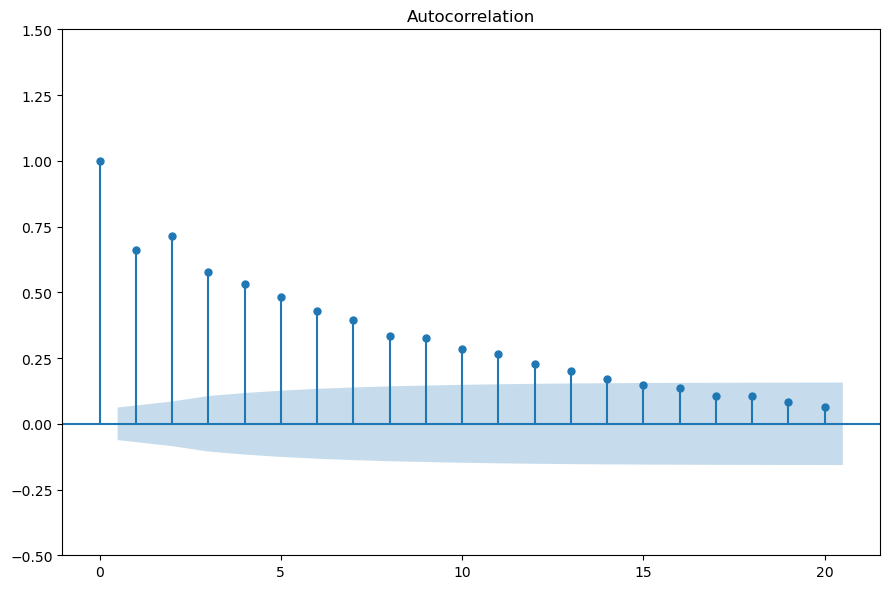

In [5]:
plot_acf(AR2_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

After lag 2 the other values are not significant. 

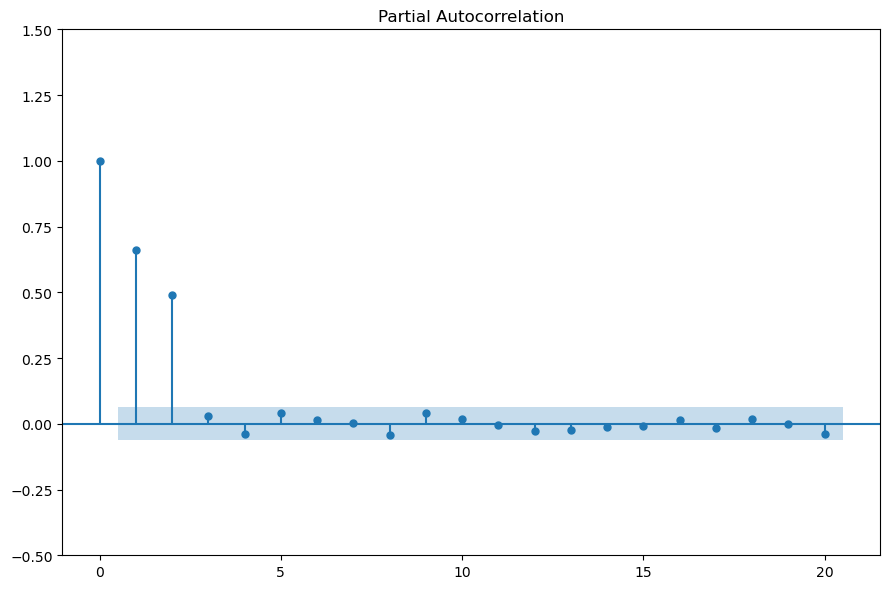

In [6]:
plot_pacf(AR2_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Forecasting with the AR(p) model 

In [10]:
df = pd.read_csv("data/simulated_AR2.csv")
df.head()

,value
0,100.000000
1,100.496714
2,100.507464
3,101.456406
4,103.270569


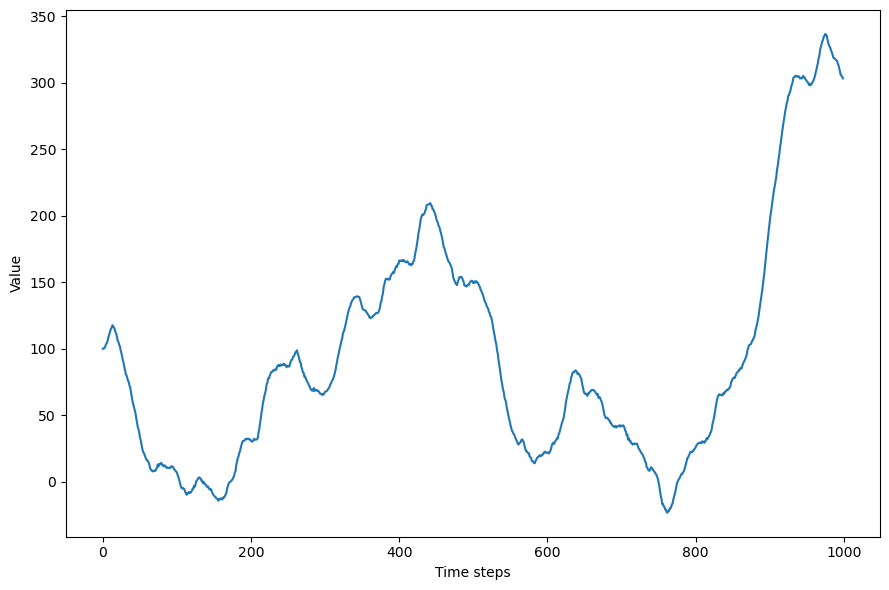

In [11]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

plt.tight_layout()

### Test for stationarity 

In [13]:
ADF_result = adfuller(df["value"])

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

# p > 0.05 - process is not stationary

ADF Statistic: -1.1218683768898152
p-value: 0.7062727342770779


### Transform and test for stationarity again 

In [15]:
# Difference the series and run the ADF test
value_diff = np.diff(df["value"], n=1)
ADF_result = adfuller(value_diff)


print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

# p < 0.05 - process is not stationary

ADF Statistic: -5.565515624443829
p-value: 1.5079043416320668e-06


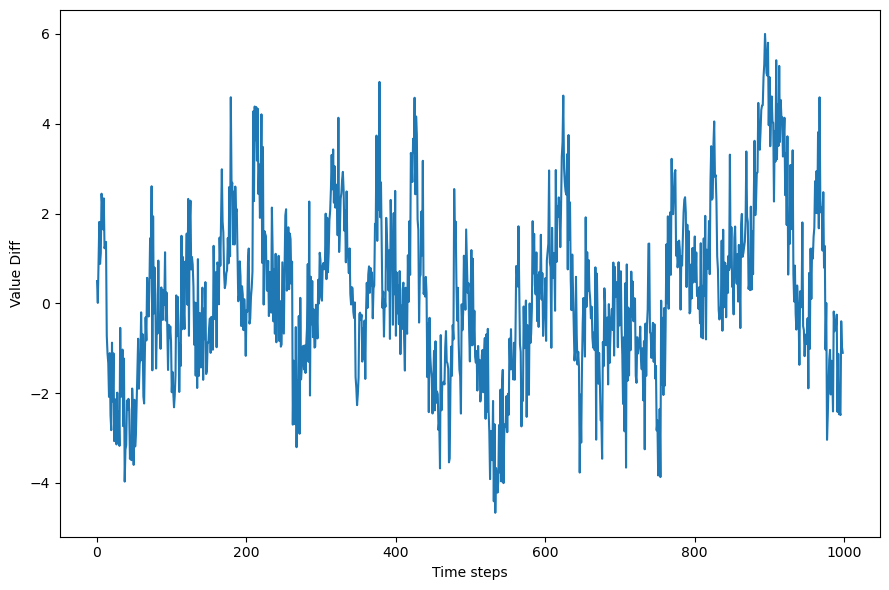

In [16]:
fig, ax = plt.subplots()

ax.plot(value_diff)
ax.set_xlabel("Time steps")
ax.set_ylabel("Value Diff")

plt.tight_layout()

### Plot ACF 

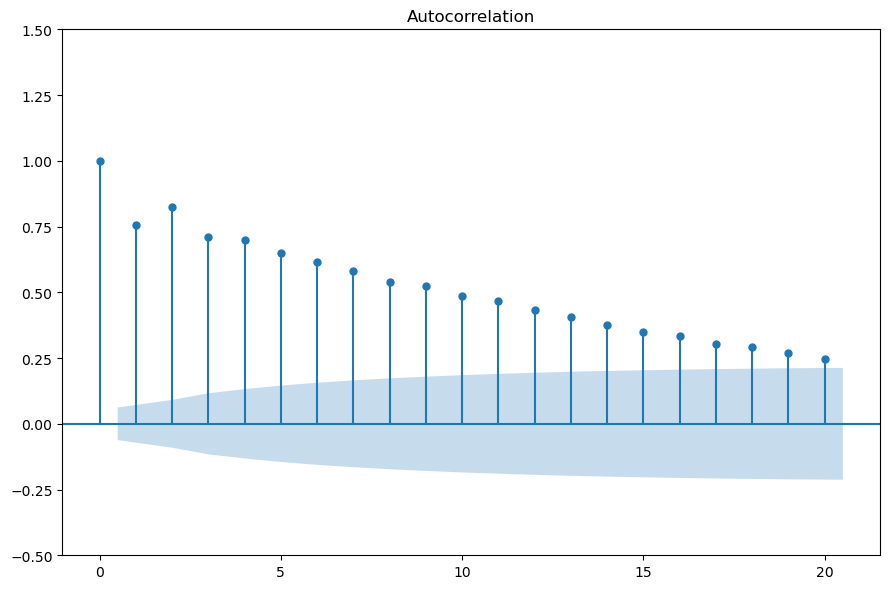

In [22]:
plot_acf(value_diff, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

### Plot PACF 

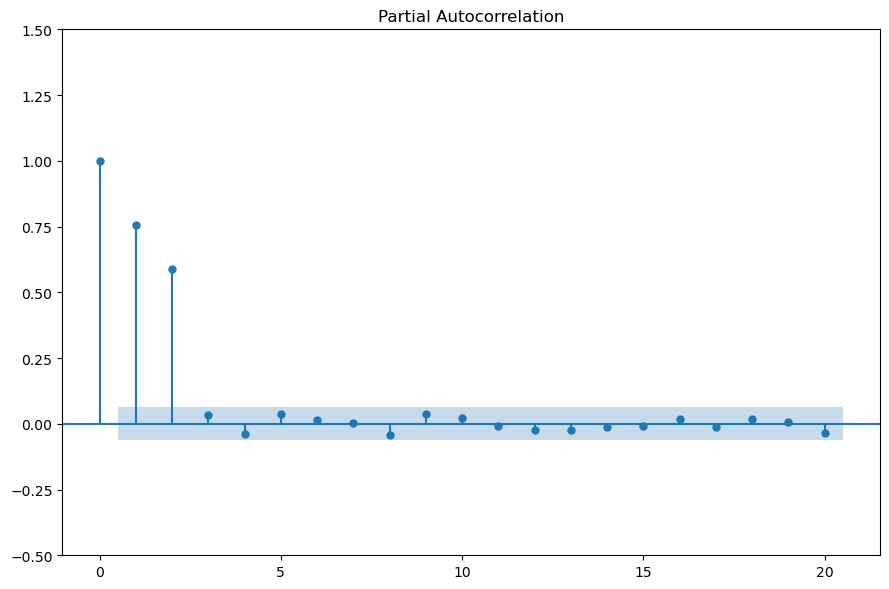

In [20]:
plot_pacf(value_diff, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

### Train/test split 

In [25]:
df_diff.shape

(999, 1)

In [24]:
df_diff = pd.DataFrame({"value_diff": value_diff})

train = df_diff[:-100]
test = df_diff[-100:]

print(len(train))
print(len(test))

899
100


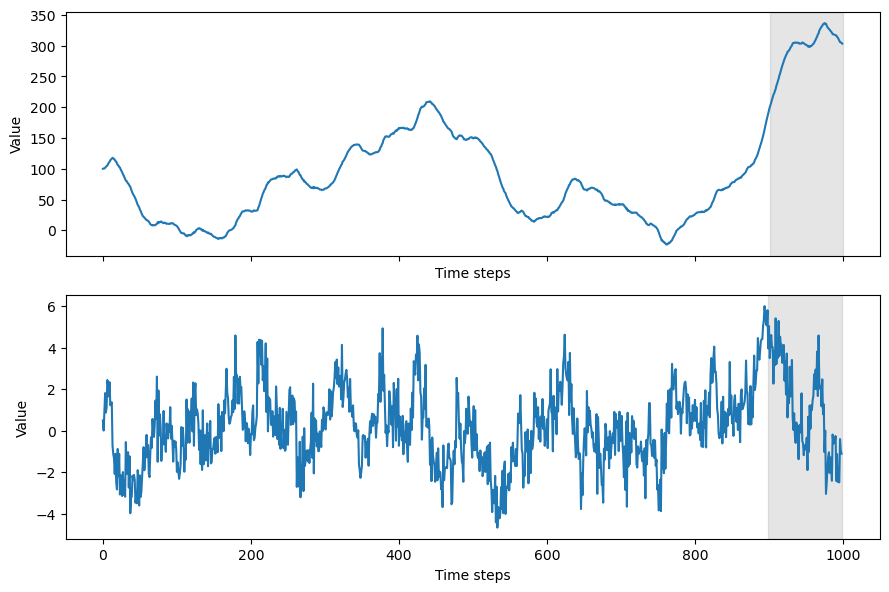

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['value'])
ax1.set_xlabel('Time steps')
ax1.set_ylabel('Value')
ax1.axvspan(901, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['value_diff'])
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Value')
ax2.axvspan(899, 998, color='#808080', alpha=0.2)

plt.tight_layout()

### Forecast 

In [28]:
def rolling_predictions(df_diff: pd.DataFrame, last_train_value: np.array, train_len: int, horizon: int, window: int, method: str) -> list:
    
    TOTAL_LEN = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df_diff[:i].values)
            pred_mean.extend(mean for _ in range(window))

        pred_mean = np.concatenate((last_train_value, pred_mean))
        pred_mean = pred_mean.cumsum()
        
        return pred_mean[:100]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = df_diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        pred_last_value = np.concatenate((last_train_value, pred_last_value))
        pred_last_value = pred_last_value.cumsum()
        
        return pred_last_value[:100]
    
    if method == 'AR':
        # Get the predictions from the AR model
        pred_AR = []

        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df_diff[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]

            pred_AR.extend(oos_pred)      

        pred_AR = np.concatenate((last_train_value, pred_AR))
        pred_AR = pred_AR.cumsum()      

        return pred_AR[:100]

In [29]:
pred_df = df[-100:].copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = df.iloc[899].values

windows = [1, 2, 5, 10]

for window in windows:
    pred_mean = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'mean')
    pred_last = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    pred_AR = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'AR')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_{window}'] = pred_last
    pred_df[f'pred_AR_{window}'] = pred_AR

pred_df.head()

,value,pred_mean_1,pred_last_1,pred_AR_1,pred_mean_2,pred_last_2,pred_AR_2,pred_mean_5,pred_last_5,pred_AR_5,pred_mean_10,pred_last_10,pred_AR_10
900,194.932437,190.964834,190.964834,190.964834,190.964834,190.964834,190.964834,190.964834,190.964834,190.964834,190.964834,190.964834,190.964834
901,199.973978,191.066019,196.769146,195.747786,191.066019,196.769146,195.747786,191.066019,196.769146,195.747786,191.066019,196.769146,195.747786
902,203.473664,191.171499,200.736749,200.371169,191.167203,202.573457,200.635773,191.167203,202.573457,200.635773,191.167203,202.573457,200.635773
903,207.577239,191.282458,205.778290,204.265177,191.278162,207.614998,204.529780,191.268388,208.377769,204.961730,191.268388,208.377769,204.961730
904,212.186574,191.397174,209.277975,208.299480,191.389121,212.656539,208.690218,191.369572,214.182080,209.171915,191.369572,214.182080,209.171915


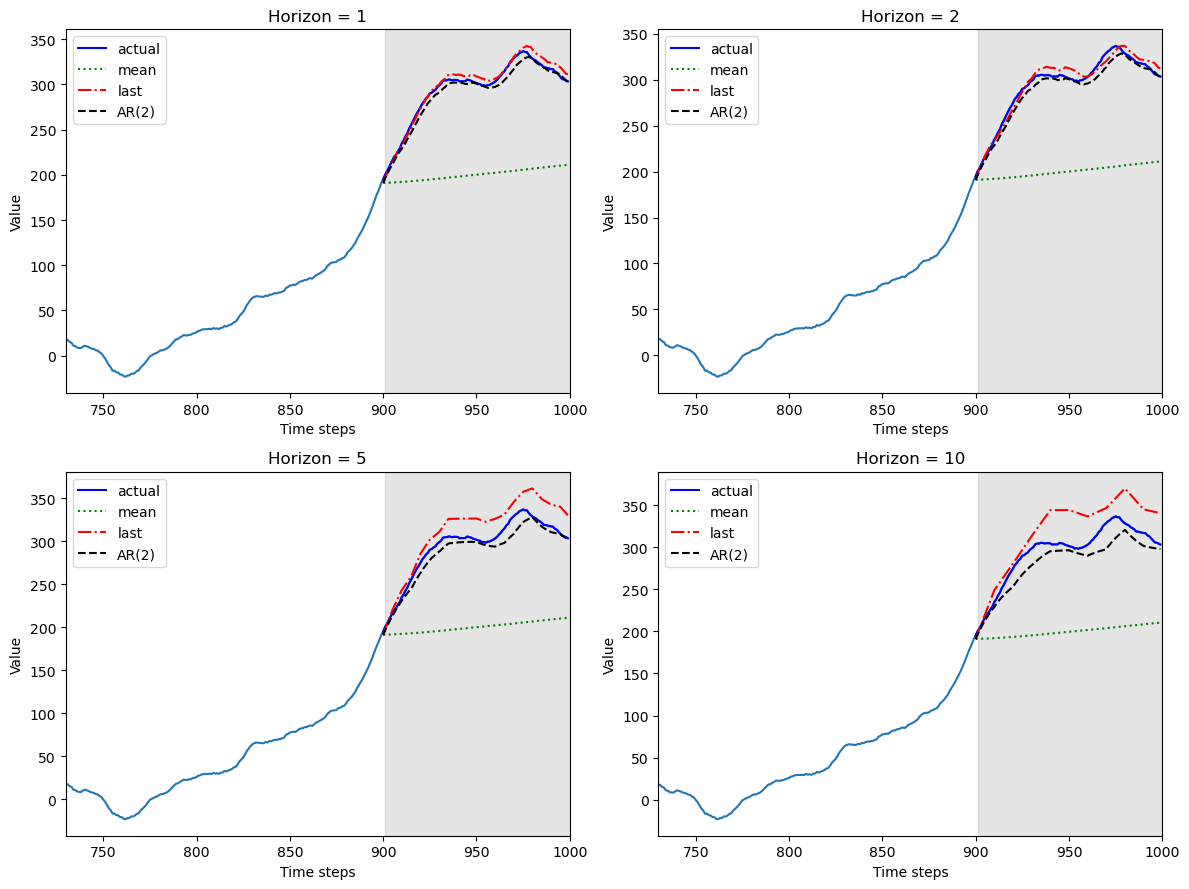

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'pred_AR_{windows[i]}'], 'k--', label='AR(2)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.axvspan(901, 1000, color='#808080', alpha=0.2)
    ax.set_xlim(730, 1000)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

In [31]:
from sklearn.metrics import mean_absolute_error

mae_mean_1 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_1'])
mae_last_1 = mean_absolute_error(pred_df['value'], pred_df['pred_last_1'])
mae_AR_1 = mean_absolute_error(pred_df['value'], pred_df['pred_AR_1'])

mae_mean_2 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_2'])
mae_last_2 = mean_absolute_error(pred_df['value'], pred_df['pred_last_2'])
mae_AR_2 = mean_absolute_error(pred_df['value'], pred_df['pred_AR_2'])

mae_mean_5 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_5'])
mae_last_5 = mean_absolute_error(pred_df['value'], pred_df['pred_last_5'])
mae_AR_5 = mean_absolute_error(pred_df['value'], pred_df['pred_AR_5'])

mae_mean_10 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_10'])
mae_last_10 = mean_absolute_error(pred_df['value'], pred_df['pred_last_10'])
mae_AR_10 = mean_absolute_error(pred_df['value'], pred_df['pred_AR_10'])

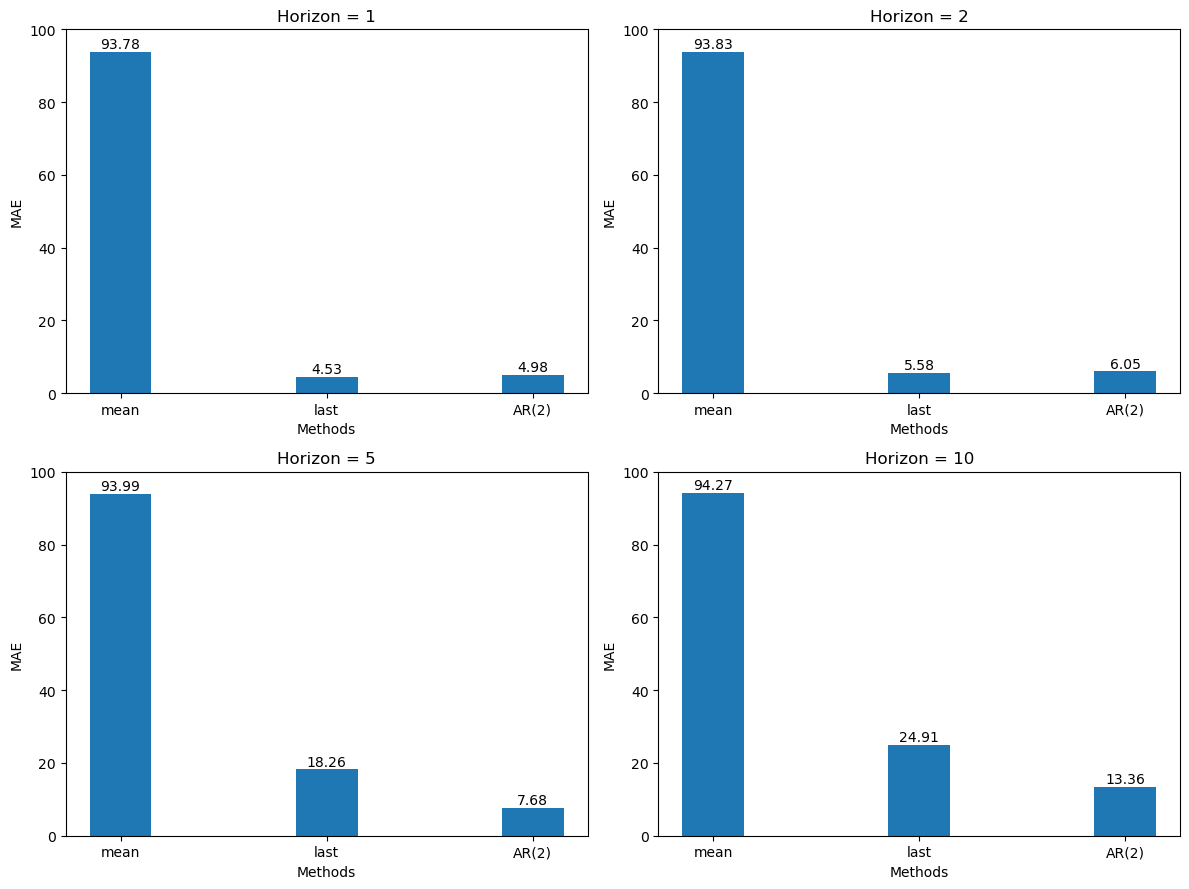

In [32]:
maes_mean = [mae_mean_1, mae_mean_2, mae_mean_5, mae_mean_10]
maes_last = [mae_last_1, mae_last_2, mae_last_5, mae_last_10]
maes_AR = [mae_AR_1, mae_AR_2, mae_AR_5, mae_AR_10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['mean', 'last', 'AR(2)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [maes_mean[i], maes_last[i], maes_AR[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 100)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

plt.tight_layout()